Using cuda


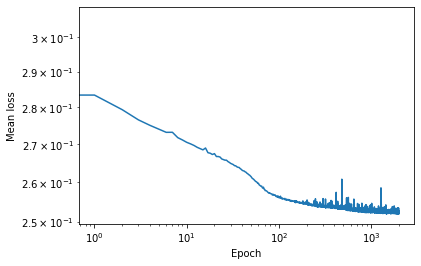

In [2]:
import numpy as np
import pickle

from scipy import ndimage
import scipy.optimize as opt
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 15
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 30

PATHS = [
    './models/hierarchical-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1/0.5beta'
]
PATH = PATHS[0]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = PATH + '.pt'
)

# Load dataset
if False:
    train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    print("Training dataset length:", len(train_dataset))

# Plot loss history
with open(PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [9]:
# Load previously generated physiology data

mode = 'SAVE'
path = './virtual_physiology/hierarchical-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1/0.5beta'

if mode == 'SAVE':
    data = {
        "physiology_data_group1": physiology_data_group1,
        "physiology_data_group2": physiology_data_group2,
        "averaged_stimuli_group1": averaged_stimuli_group1,
        "averaged_stimuli_group2": averaged_stimuli_group2
    }

    with open(path, 'wb') as handler:
        pickle.dump(data, handler)
elif mode == 'LOAD':
    with open(path, 'rb') as handler:
        data = pickle.load(handler)
        
        physiology_data_group1 = data["physiology_data_group1"]
        physiology_data_group2 = data["physiology_data_group2"]
        averaged_stimuli_group1 = data["averaged_stimuli_group1"]
        averaged_stimuli_group2 = data["averaged_stimuli_group2"]

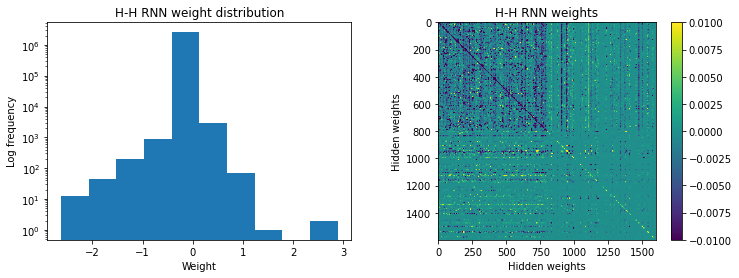

In [6]:
# Plot weight matrices and weights distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))

axs[0].hist(model.rnn.weight_hh_l0.cpu().detach().numpy().flat, log=True)
axs[0].set_xlabel('Weight')
axs[0].set_ylabel('Log frequency')
axs[0].set_title('H-H RNN weight distribution')

im = axs[1].imshow(model.rnn.weight_hh_l0.cpu().detach().numpy(), vmin=-0.01, vmax=0.01)
axs[1].set_xlabel('Hidden weights')
axs[1].set_ylabel('Hidden weights')
axs[1].set_title("H-H RNN weights")
plt.colorbar(im)

In [ ]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 250

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Random noise trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())
                
averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Averaging across hidden unit {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

In [ ]:
# Virtual physiology

def plot_grating_animation (gratings): # Will only work when called (or output called)
                                       # at end of notebook
    fig = plt.figure(dpi=40)
    init_data = gratings.cpu().detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    plt.close()
    def animate(i):
        im_data = gratings.cpu().detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=WARMUP+T_STEPS, interval=100
    )
    
    return HTML(anim.to_jshtml())

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d):
        return a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    offset = 7 # Discard how much of beginning of activity
    MSE_threshold = 10

    # Because the unit output has a floor of 0, the curve optimizer function might
    # fail to fit the function unless we shift the unit's response up
    # Shift it up by 0-150, returning the increment (shift), parameters and MSE for each increment
    for i in range(0, 150, 10):
        x = np.arange(len(activity[offset:]))
        y = np.array(activity[offset:]) + i

        # In case it fails to find optimal parameters, wrap in a try block
        try:
            bounds = (
                [-np.inf, 1, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, np.inf] # Set lower bound of 1 for frequency
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    # Return false if no good fits were found for any combination
    if len(params):
        # Get the index of the lowest MSE, use this to find the
        # Corresponding parameters used
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]
        best_mse = mse[idx]

        f0 = np.mean(activity[offset:]) # Average unit activity
        f1 = (abs(best_params[0])) # Absolute of the amplitude of the fitted sine

        y_est = func(np.arange(len(activity[offset:])), *best_params) - best_i
    
        if best_mse <= MSE_threshold and f0 != 0: # Reject f values for those units with poor sine fits
            return f1/f0, y_est                   # as these are unlikely to be reliable
        else:
            return False, False
    else:
        return False, False

def generate_gratings (frequency, rotation):
    gratings = []
    for i in range(WARMUP+T_STEPS+1):
        extended_val = 4 # For a full field grating, make it 4 times larger than
                         # the frame so it can be cropped when rotated and still be full-field
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice( # Crop extended size grating to be the same size as the frame
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = np.pi*-i*0.5 # Shift  by -pi/2 each timestep

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*frequency*extended_val + phase)

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, rotation-90, reshape=False) # -90 to correct for fact that 'default' is 90deg/horizontal
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

# Returns a dict of grating responses { unit_idx: responses_array }
def get_grating_responses (model, grating, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(grating)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

# Returns array of physiology data
# { "unit_idx", "tuning_curve", "sf", "orientation", "preferred_response", "f" }
def get_physiology_data (averaged_hidden_units):
    offset = 5 # Discard response to first 5 frames
    hidden_unit_rfs, hidden_unit_idxs = averaged_hidden_units
    
    physiology_data = []

    spatial_frequencies = np.arange(0.5, 4.5, 0.5)
    orientations = np.arange(0, 190, 10)

    response_tuning_curves = {}
    for idx in hidden_unit_idxs:
        response_tuning_curves[idx] = np.zeros((len(spatial_frequencies), len(orientations)))

    for row, sf in enumerate(spatial_frequencies):
        for col, deg in enumerate(orientations):
            gratings = generate_gratings(sf, deg)
            grating_responses = get_grating_responses(model, gratings, hidden_unit_idxs)
                
            for idx in hidden_unit_idxs:
                response_tuning_curves[idx][row, col] = np.mean(grating_responses[idx][offset:]) # Get mean response for that
                                                                                                 # sf, orientation combo
        print("Finished SF ", sf) 
    print("Finished tuning curve")

    for i, unit_idx in enumerate(response_tuning_curves):
        tuning_curve = response_tuning_curves[unit_idx]
        
        sf_idx, orient_idx = np.where(tuning_curve >= np.max(tuning_curve))
        max_sf, max_orient = spatial_frequencies[sf_idx[0]], orientations[orient_idx[0]]
        
        gratings = generate_gratings(max_sf, max_orient)
        grating_response = get_grating_responses(model, gratings, hidden_unit_idxs)[unit_idx]

        f, y_est = get_f_value(grating_response)
        
        physiology_data.append({
            "unit_idx": unit_idx,
            "rf": hidden_unit_rfs[np.where(hidden_unit_idxs == unit_idx)[0]],
            "tuning_curve": tuning_curve,
            "sf": max_sf,
            "orientation": max_orient,
            "preferred_response": grating_response,
            "mean_response": np.mean(grating_response),
            "f": f,
            "y_est": y_est
        })

        if i % 100 == 99:
            print("Finished unit {} / {}".format(i+1, len(hidden_unit_idxs)))

    print("Finished all physiology data processing")

    return physiology_data

# Graphs is an array of ["rf", "tuning_curve", "preferred_response"]
def plot_physiology_data (unit, graphs):
    if "rf" in graphs:
        sta = normalize(unit["rf"])
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()

    if "tuning_curve" in graphs:
        spatial_frequencies = np.arange(0.5, 4.5, 0.5)
        orientations = np.arange(0, 190, 10)

        fig, ax = plt.subplots(dpi=100)
        plt.imshow(unit["tuning_curve"])
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(orientations)), orientations, size=6) 
        plt.ylabel("SF")
        plt.yticks(range(len(spatial_frequencies)), spatial_frequencies, size=6)
        plt.title("Max unit activity as a function of orientation and SF", size=8)
        plt.show()

    if "preferred_response" in graphs:
        fig = plt.figure()
        plt.plot(unit["preferred_response"])
        if unit["f"]:
            plt.plot(np.arange(7, T_STEPS), unit["y_est"])
        plt.xlabel("Frame (phase)")
        plt.ylabel("Activity")
        plt.title(
            "Activity for SF = {}, orientation = {}, unit {}".format(
                unit["sf"], unit["orientation"], unit["unit_idx"]
            )
        )
        plt.show()

physiology_data_group1 = get_physiology_data(averaged_stimuli_group1)
physiology_data_group2 = get_physiology_data(averaged_stimuli_group2)

In [52]:
# Spatial localisation of units

def generate_gabors (sf, orientation, gabor_size, row, col):
    # Code sample from https://stackoverflow.com/a/46892763
    def gkern(kernlen, std):
        gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        return gkern2d

    gabor_envelope = gkern(gabor_size, gabor_size/5)
    gratings = generate_gratings(sf, orientation).reshape(-1, FRAME_SIZE, FRAME_SIZE)

    im_width = FRAME_SIZE+gabor_size
    im = np.zeros((im_width, im_width)) # Padded size to frame + half of gabor width on each side
    im[row:row+gabor_size, col:col+gabor_size] = gabor_envelope # Set gabor envelope at x,y position
    im = im[gabor_size//2:FRAME_SIZE+gabor_size//2, gabor_size//2:FRAME_SIZE+gabor_size//2] # Crop to remove padding
    gabor = im * gratings.cpu().detach().numpy() # Convolve grating with gaussian kernel
    gabor = gabor.reshape((-1, FRAME_SIZE**2))
    gabor = torch.Tensor(gabor).unsqueeze(0).to(DEVICE)

    return gabor

def get_spatial_position (unit):
    unit_idx = unit["unit_idx"]
    
    gabor_sizes = [8, 14, 20, 40]
    spatial_responses = np.zeros((len(gabor_sizes), FRAME_SIZE, FRAME_SIZE)) # (gabor size, frame size, frame size)
    
    for i, gabor_size in enumerate(gabor_sizes):
        for row in range(FRAME_SIZE):
            for col in range(FRAME_SIZE):
                gabors = generate_gabors(unit["sf"], unit["orientation"], gabor_size, row, col)
                response = get_grating_responses(model, gabors, [unit_idx])[unit_idx]
                spatial_responses[i, row, col] = np.mean(response[5:])

    weighted_max_rows, weighted_max_cols, response_weights = [], [], []
    for gabor_size in range(len(gabor_sizes)): # Get location of max response for each gabor size
        responses = spatial_responses[gabor_size]

        max_response = np.max(responses)
        max_row, max_col = np.where(responses == max_response)

        weighted_max_rows.append(max_row[0]*max_response)
        weighted_max_cols.append(max_col[0]*max_response)
        response_weights.append(max_response)
    
    if np.sum(response_weights) == 0: # We couldn't find a gabor that gave a response :(
        return -1, -1
    else:
        mean_max_row = int(round(np.sum(weighted_max_rows) / np.sum(response_weights)))
        mean_max_col = int(round(np.sum(weighted_max_cols) / np.sum(response_weights)))
        return mean_max_row, mean_max_col

def get_group_spatial_positions (physiology_data):
    for i, unit in enumerate(physiology_data): 
        position = get_spatial_position(unit)
        physiology_data[i]["position"] = position
        
        if i % 10 == 9:
            print("Processed unit {} / {}".format(i+1, len(physiology_data)))
    print("\nProcessed all units\n")
    
get_group_spatial_positions(physiology_data_group1)
get_group_spatial_positions(physiology_data_group2)

Processed unit 10 / 587
Processed unit 20 / 587
Processed unit 30 / 587
Processed unit 40 / 587
Processed unit 50 / 587
Processed unit 60 / 587
Processed unit 70 / 587
Processed unit 80 / 587
Processed unit 90 / 587
Processed unit 100 / 587
Processed unit 110 / 587
Processed unit 120 / 587
Processed unit 130 / 587
Processed unit 140 / 587
Processed unit 150 / 587
Processed unit 160 / 587
Processed unit 170 / 587
Processed unit 180 / 587
Processed unit 190 / 587
Processed unit 200 / 587
Processed unit 210 / 587
Processed unit 220 / 587
Processed unit 230 / 587
Processed unit 240 / 587
Processed unit 250 / 587
Processed unit 260 / 587
Processed unit 270 / 587
Processed unit 280 / 587
Processed unit 290 / 587
Processed unit 300 / 587
Processed unit 310 / 587
Processed unit 320 / 587
Processed unit 330 / 587
Processed unit 340 / 587
Processed unit 350 / 587
Processed unit 360 / 587
Processed unit 370 / 587
Processed unit 380 / 587
Processed unit 390 / 587
Processed unit 400 / 587
Processed

In [ ]:
# Visualise connections between recurrent units
averaged_stimuli = averaged_stimuli_group1

starting_idx = 0
n_units = 15
units_slice = slice(starting_idx, starting_idx+n_units)

hh_indices = averaged_stimuli[1][units_slice]
hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for row in range(n_units):
    for col in range(n_units):
        hh_weights_subset[row, col] = hh_weights[hh_indices[row], hh_indices[col]]

sta_RFs = max_abs_normalize(averaged_stimuli_group1[0][units_slice])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='bwr', vmax=1, vmin=-1)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(sta_RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.5, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

In [ ]:
# Plot distribution of connections

averaged_stimuli = averaged_stimuli_group1

# Get subset of weights for those units which have STA estimates
weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
unit_idxs = averaged_stimuli[1]
unit_idxs_inhib = averaged_stimuli[1][:72]
unit_idxs_excit = averaged_stimuli[1][72:]
weights_subset = weights[unit_idxs, :] # Rows
weights_subset = weights_subset[:, unit_idxs] # Columns

# Shuffle to see if there's any real effect (proto stats-test)
if False:
    np.random.shuffle(weights_subset)
    np.random.shuffle(np.transpose(weights_subset))

# Normalize weights and find threshold (greater than 2 std's)
weights_subset = (weights_subset-np.mean(weights_subset)) / np.std(weights_subset)
threshold = 2

orientation_deltas = []
mean_orientation_deltas = []

for post_unit_idx in range(len(unit_idxs)):
    unit_orientation_deltas = []
    for pre_unit_idx in range(len(unit_idxs)):
        if abs(weights_subset[post_unit_idx, pre_unit_idx]) >= threshold:
            pre_unit = physiology_data_group1[pre_unit_idx]
            post_unit = physiology_data_group1[post_unit_idx]
            
            a1, a2 = pre_unit["orientation"], post_unit["orientation"]
            adelta = 180 - abs(abs(a1 - a2) - 180)
            orientation_deltas.append(adelta)
            unit_orientation_deltas.append(adelta)
    if len(unit_orientation_deltas):
        mean_orientation_deltas.append(np.mean(unit_orientation_deltas))

orientation_deltas = np.array(orientation_deltas)
mean_orientation_deltas = np.array(mean_orientation_deltas)
        
shift = 45
        
shifted_orientation_deltas = (orientation_deltas+shift)%180
shifted_mean_orientation_deltas = (mean_orientation_deltas+shift)%180

weights_ods = np.ones_like(shifted_orientation_deltas) / float(len(orientation_deltas))
weights_shifted_ods = np.ones_like(shifted_mean_orientation_deltas) / float(len(mean_orientation_deltas))
    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))
axs[0].hist(shifted_orientation_deltas, bins=18, weights=weights_ods)
axs[0].set_title("Overall Δ orient. between units, all inputs")
axs[0].set_xlabel("Δ orientation angle")
axs[0].set_xticks(np.arange(0, 200, 20))
axs[0].set_xticklabels(np.arange(0-shift, 200-shift, 20))

axs[1].hist(shifted_mean_orientation_deltas, bins=18, weights=weights_shifted_ods)
axs[1].set_title("Mean Δ orient. for each postsynaptic unit, all inputs")
axs[1].set_xlabel("Δ orientation angle")
axs[1].set_xticks(np.arange(0, 200, 20))
axs[1].set_xticklabels(np.arange(0-shift, 200-shift, 20))

plt.show()

orientations = []
for i in range(len(unit_idxs)):
    orientations.append(physiology_data_group1[i]["orientation"])
orientations = np.array(orientations)
weights = np.ones_like(orientations) / float(len(orientations))

fig, ax = plt.subplots()
ax.hist((orientations+shift)%180, bins=18, weights=weights)
ax.set_title("Orientation tunings in group 1, all inputs")
ax.set_xlabel("Orientation angle")
ax.set_xticks(np.arange(0, 200, 20))
ax.set_xticklabels(np.arange(0-shift, 200-shift, 20))

1.6242235 11.785926


Text(0.5, 0.98, 'F values (> 1 indicates a simple cell)')

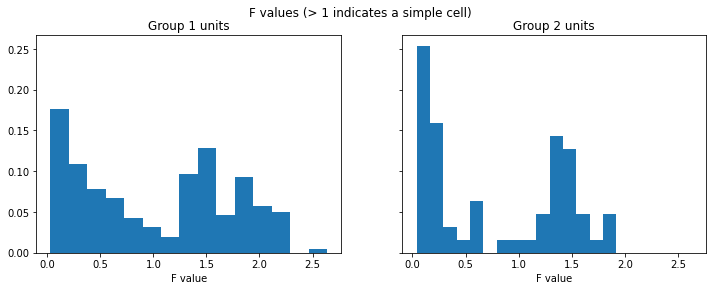

In [32]:
outlier_thresh = 5

max_mean_response_1 = max(u['mean_response'] for u in physiology_data_group1)
max_mean_response_2 = max(u['mean_response'] for u in physiology_data_group2)

print(max_mean_response_1, max_mean_response_2)

f_values_1 = []
for i in range(len(averaged_stimuli_group1[1])):
    unit = physiology_data_group1[i]
    f = unit["f"]
    if f != False and f < outlier_thresh and unit["mean_response"] > (0.01*max_mean_response_1):
        f_values_1.append(f)
f_values_1 = np.array(f_values_1)
weights_1 = np.ones_like(f_values_1) / float(len(f_values_1))
    
f_values_2 = []
for i in range(len(averaged_stimuli_group2[1])):
    unit = physiology_data_group2[i]
    f = unit["f"]
    if f != False and f < outlier_thresh and unit["mean_response"] > (0.01*max_mean_response_2):
        f_values_2.append(f)
f_values_2 = np.array(f_values_2)
weights_2 = np.ones_like(f_values_2) / float(len(f_values_2))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)
axs[0].hist(f_values_1, bins=15, weights=weights_1)
axs[0].set_title("Group 1 units")
axs[0].set_xlabel("F value")
axs[1].hist(f_values_2, bins=15, weights=weights_2)
axs[1].set_title("Group 2 units")
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

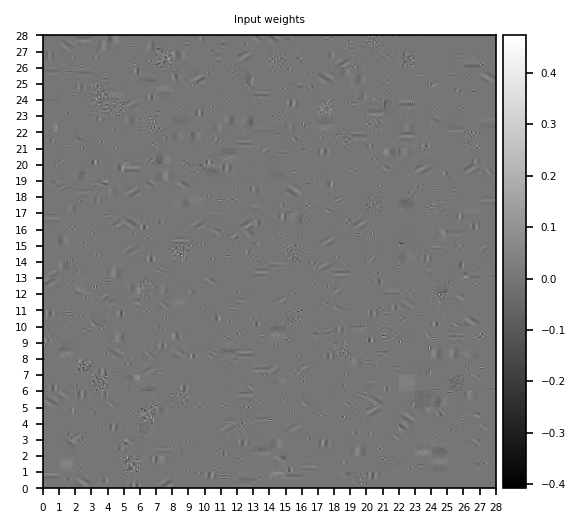

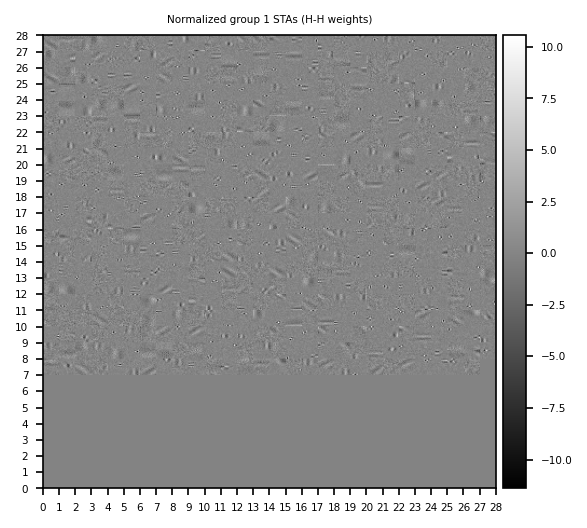

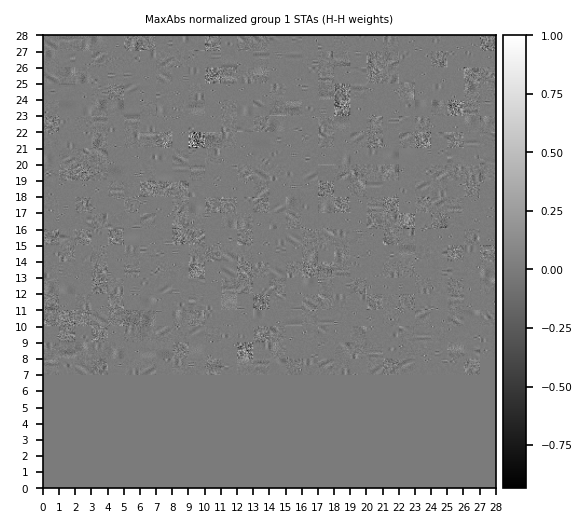

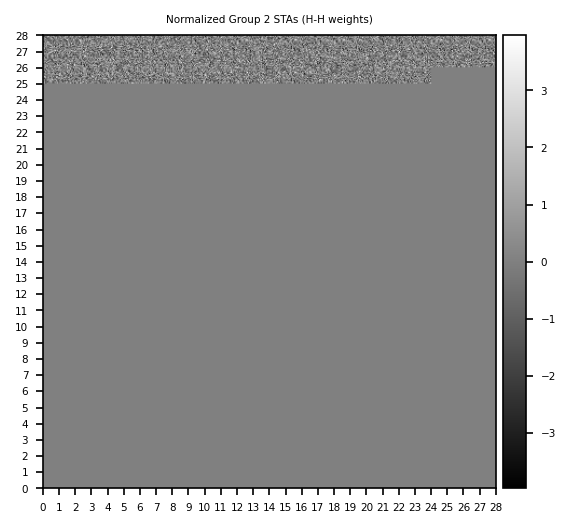

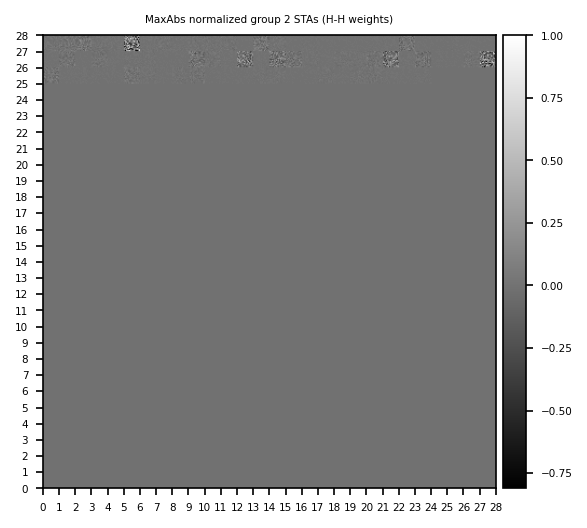

In [10]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=150)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")